In [1]:
from neuron import h
import pandas as pd
import numpy as np
import json
import os
from typing import Optional, List, Tuple, Union

from cell_inference.cells.simulation import Simulation
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.config import params, paths

h.load_file('stdrun.hoc')
h.nrn_load_dll(paths.COMPILED_LIBRARY_REDUCED_ORDER)
geo_standard = pd.read_csv(paths.GEO_REDUCED_ORDER, index_col='id')
h.dt = params.DT
h.steps_per_ms = 1/h.dt

h.tstop = 400.

### Setup smiulation parameters

In [2]:
# Biophysical parameters
filepath = './cell_inference/resources/biophys_parameters/ReducedOrderL5.json'
with open(filepath) as f:
    biophys_param = json.load(f)

In [3]:
# Ra: basal, prox trunk, tuft, axon, passive basal
g_syn = 3.5 # multiple of g_leak
e_tot = (-72.0 * 1 + 0. * g_syn) / (1 + g_syn)
g_tot = (1 + g_syn) * 0.0000589
biophys = [e_tot, g_tot]
biophys_comm = {}
geo_param = [545.] # 5 - 595 um
loc_param = [0., 0., 0., 0., 1., 0.] # position (x,y,z,alpha,h,phi)

In [4]:
ncell = 1
biophys = np.tile(biophys,(ncell,1)) 
# biophys[:,5] = np.linspace(200, 300, ncell)
biophys = np.append(biophys,biophys[[0],:],axis=0)
print(biophys)

[[-1.6000e+01  2.6505e-04]
 [-1.6000e+01  2.6505e-04]]


In [5]:
geo_param = np.tile(geo_param,(ncell,1))
# geo_param[:,6] = np.linspace(.1, .2, ncell)
# geo_param[:,[2,3,4,6]] *= 1.0 # scale radius
geo_param = np.append(geo_param,geo_param[[0],:],axis=0)
print(geo_param)

[[545.]
 [545.]]


In [6]:
gmax = [0.]*ncell + [0.013]
ncell += 1

In [7]:
sim = Simulation(geometry = geo_standard,
                 electrodes = params.ELECTRODE_POSITION,
                 full_biophys = biophys_param,
                 cell_type = CellTypes.REDUCED_ORDER,
                 biophys = biophys,
                 biophys_comm = biophys_comm,
                 loc_param = loc_param,
                 geo_param = geo_param,
                 gmax = gmax,
                 stim_param = {'start': 200.},
                 scale = 1.,
                 ncell = ncell)

#### Add current injection

In [8]:
for cell in sim.cells[:-1]:
    cell.add_injection(sec_index=0, pulse=True, record=True, amp=-0.010, delay=200.0, dur=200.0)

#### Record membrane potential

In [9]:
V_rec = Recorder(sim.cells[-1].segments)

### Simulation results

In [10]:
sim.run_neuron_sim()
# lfp = sim.get_lfp().T
t = sim.t()
v = sim.v('all')

#### Membrane voltage

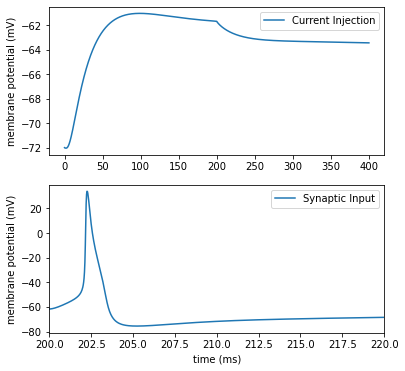

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(6,6))
plt.subplot(211)
plt.plot(t,v[0],label='Current Injection')
plt.ylabel('membrane potential (mV)');
plt.legend(loc=1)
plt.subplot(212)
plt.plot(t,v[-1],label='Synaptic Input')
plt.ylabel('membrane potential (mV)');
plt.legend(loc=1)
plt.xlabel('time (ms)')
plt.xlim([sim.stim.start, sim.stim.start + 20])
plt.show()

#### Calculate passive properties

In [12]:
from cell_inference.utils.metrics.measure_passive_properties import measure_passive_properties
%matplotlib inline

# plt.figure(figsize=(6,3*(ncell-1)))
# for i in range(ncell-1):
#     plt.subplot(ncell-1,1,i+1)
#     Vrest, Rin, Tau = measure_passive_properties(v[i],t,sim.cells[i].injection[0].pp_obj,ax=plt.gca())
#     print((Vrest, Rin, Tau))

for i in range(ncell-1):
    Vrest, Rin, Tau = measure_passive_properties(v[i],t,sim.cells[i].injection[0].pp_obj)
    print((Vrest, Rin, Tau))

(-61.66718126493182, 176.47075347092667, 26.649999999975762)


#### Get segment coordinates for given cell and calculate electrotonic distance

In [13]:
from cell_inference.utils.metrics.measure_segment_distance import measure_segment_distance

cell = sim.cells[-1]
soma = cell.soma
section_list = cell.all
sec_type_swc = {sec['name']: sec['type'] for _, sec in geo_standard.iterrows()}
sec_type = [sec_type_swc[sec.name().split('.')[-1]] for sec in section_list]
freq = 0 # Hz

seg_prop, Rin, Rin_pha = measure_segment_distance(soma, section_list, sec_type, freq)
print(Rin, Rin_pha) # Megohms, rad

109.33246586947293 0.0


In [14]:
from cell_inference.utils.plotting.plot_variable_with_morphology import plot_variable_with_morphology
%matplotlib inline

seg_coords = cell.seg_coords

tstart = sim.stim.start
dur = 12
t = sim.t()
t_idx = (t>=tstart) & (t<=tstart+dur)
im = sim.lfp[-1].calc_im()[:, t_idx]
# im_den = im / np.expand_dims(seg_prop['seg_area'], 1) # nA/um^2
im_den = im / np.diff(seg_prop['distance'], axis=1) # nA/um

select_seg = None
# select_seg = seg_prop['swc_type'] != 1 # excluding soma

var = im_den
varname = 'Transmembrane current density per unit length (nA/um)'
axes = ['x', 'y']
n_dist = 20
max_per_dist = 1
space = 1.
normalized_space = True
sort_by_dist = True
figsize = (12,9)
fontsize = 15
scalebar_size = 50

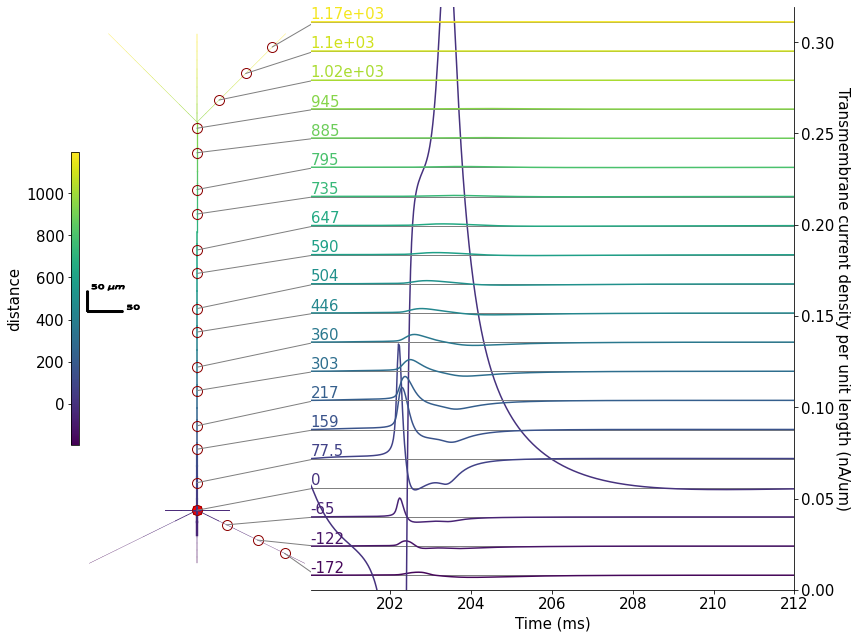

In [15]:
_ = plot_variable_with_morphology(seg_coords, seg_prop, var, t=t[t_idx], axes=axes,
                                  distance_type='distance', n_dist=n_dist,
                                  select_seg=select_seg, max_per_dist=max_per_dist, varname=varname,
                                  space=space, normalized_space=normalized_space, sort_by_dist=sort_by_dist,
                                  figsize=figsize, fontsize=fontsize, scalebar_size=scalebar_size)

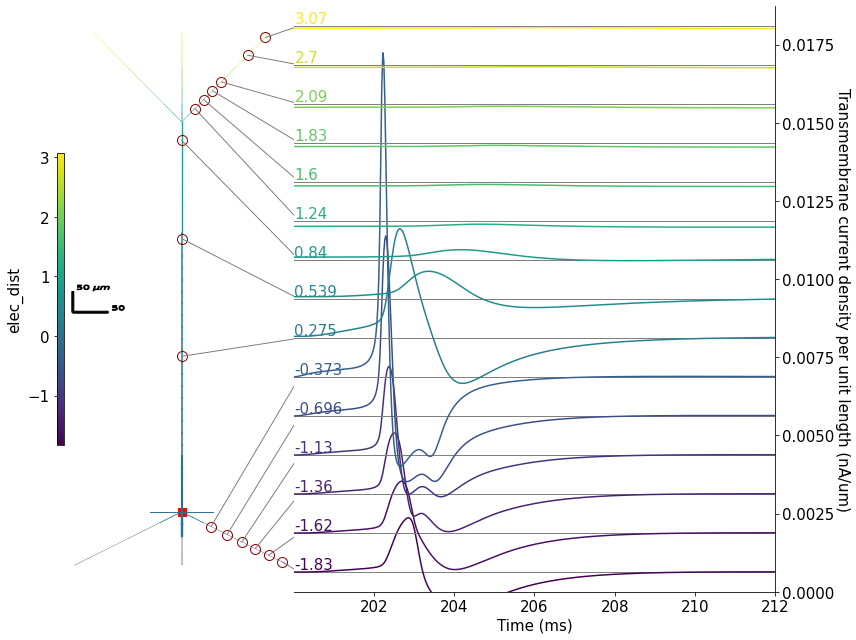

In [16]:
_ = plot_variable_with_morphology(seg_coords, seg_prop, var, t=t[t_idx], axes=axes,
                                  distance_type='elec_dist', n_dist=n_dist,
                                  select_seg=select_seg, max_per_dist=max_per_dist, varname=varname,
                                  space=space, normalized_space=normalized_space, sort_by_dist=sort_by_dist,
                                  figsize=figsize, fontsize=fontsize, scalebar_size=scalebar_size)

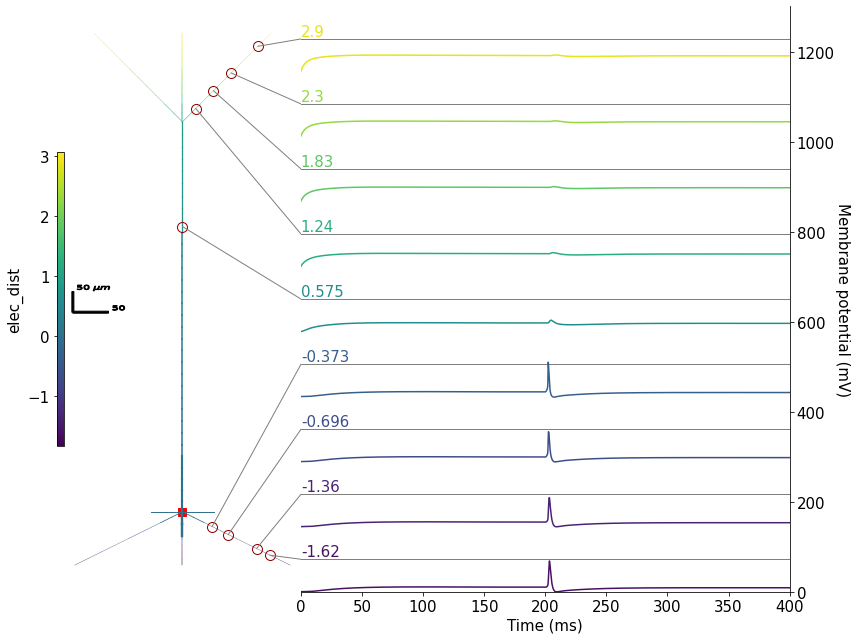

In [17]:
tstart = 0 # sim.stim.start
dur = h.tstop
t_idx = (t>=tstart) & (t<=tstart+dur)
Vm = V_rec.as_numpy()[:, t_idx]

select_seg = None
# select_seg = seg_prop['swc_type'] != 1 # excluding soma

var = Vm
varname = 'Membrane potential (mV)'
n_dist = 10
space = 2.
normalized_space = True
sort_by_dist = True

_ = plot_variable_with_morphology(seg_coords, seg_prop, var, t=t[t_idx], axes=axes,
                                  distance_type='elec_dist', n_dist=n_dist,
                                  select_seg=select_seg, max_per_dist=max_per_dist, varname=varname,
                                  space=space, normalized_space=normalized_space, sort_by_dist=sort_by_dist,
                                  figsize=figsize, fontsize=fontsize, scalebar_size=scalebar_size)

#### Plot LFP

In [18]:
from cell_inference.utils.feature_extractors.SummaryStats2D import process_lfp

loc_param = [0., 0., 80., 0., 1., np.pi*0/8]

start_idx = int(np.ceil(sim.stim_param['start']/h.dt)) # ignore signal before
lfp = sim.lfp[-1].calc_ecp(move_cell=loc_param).T[start_idx:,:]
output = process_lfp(lfp, y_window_size=2000.0, ycoord=loc_param[1], calc_summ_stats=False)

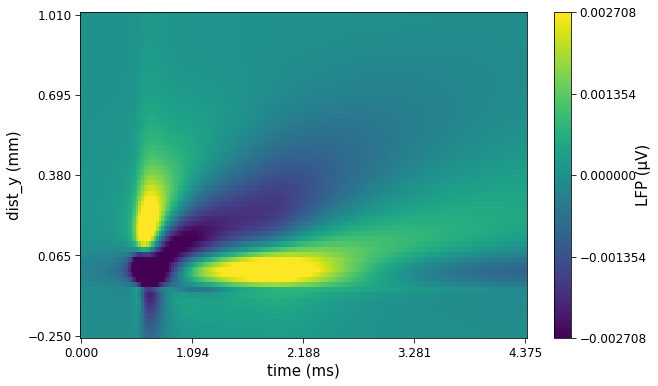

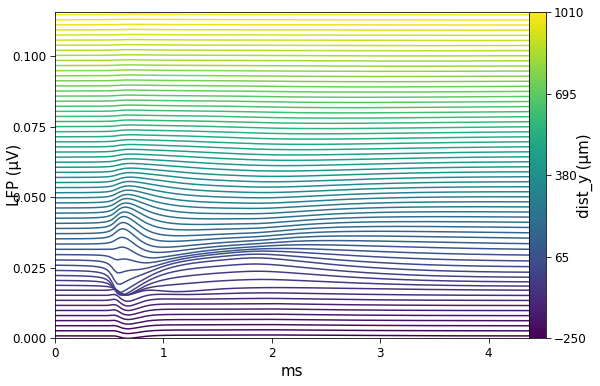

In [19]:
from cell_inference.utils.plotting.plot_results import plot_lfp_heatmap, plot_lfp_traces
%matplotlib inline

ix = 1
fontsize = 15
labelpad = -10
ticksize = 12
tick_length = 5
nbins = 5

d = output[1]
t = output[2]
coords = output[3]
x_dist = np.unique(coords[:, 0])
e_idx = coords[:, 0]==x_dist[ix]
ylim = [-250, 1100]
e_idx &= (coords[:, 1]>=ylim[0]) & (coords[:, 1]<=ylim[1])

plt.figure(figsize=(10,6))
_ = plot_lfp_heatmap(t=t, elec_d=coords[e_idx, 1], lfp=d[:, e_idx],
                     fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                     nbins=nbins, vlim='auto', axes=plt.gca())

plt.figure(figsize=(10,6))
_ = plot_lfp_traces(t, d[:, e_idx], electrodes=coords[e_idx, :],
                    fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                    nbins=nbins, axes=plt.gca())

plt.show()

#### Plot morphology

<IPython.core.display.Javascript object>


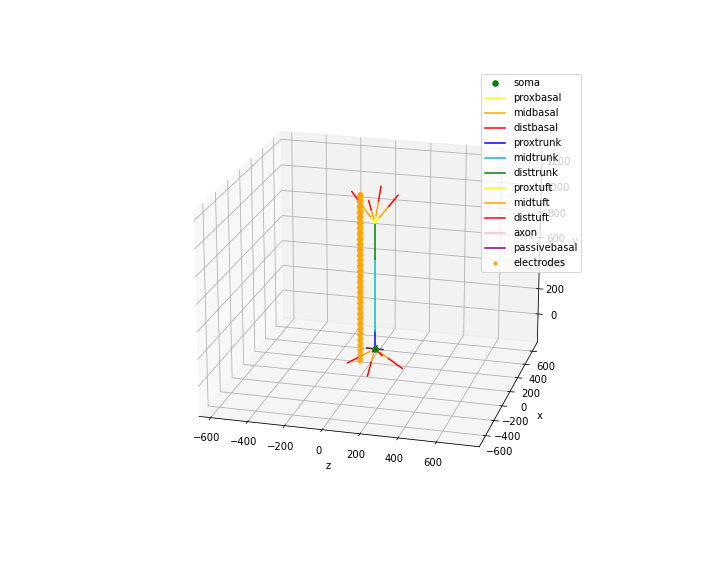

In [20]:
from cell_inference.utils.plotting.plot_morphology import plot_morphology
%matplotlib notebook

_ = plot_morphology(sim, ncell-1, electrodes=params.ELECTRODE_POSITION, move_cell=loc_param,
                    elev=20, azim=-75, figsize=(10,8),
                    clr = ['g',       #soma
                           'yellow',  #proxbasal
                           'orange',  #midbasal
                           'red',     #distbasal
                           'b',  #proxtrunk
                           'c',    #midtrunk
                           'g',   #disttrunk
                           'yellow',  #proxtuft
                           'orange',  #midtuft
                           'red',     #disttuft
                           'pink',       #axon
                           'purple']   #passivebasal
                   )